In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
mpl.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
#from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix
import eval_vis

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_seoul.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_seoul.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = eval_vis.evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'hidden_dim1': [64 , 32],
    'hidden_dim2': [32 , 16],
    'dropout': [0.2 , 0.3],
    'optimizer': ['Adam'],
    'lr': [0.001 , 0.01]
}

# 그리드 서치 수행
best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(MLP, X_train, y_train, train_loader, param_grid, X_train.shape[1], 1, num_epochs=10, batch_size=32)



{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 210.1355, Test Loss: 4.1830, Sensitivity: 0.9568
Epoch [2/10], Train Loss: 50.2052, Test Loss: 3.0295, Sensitivity: 0.9433
Epoch [3/10], Train Loss: 45.1162, Test Loss: 3.2395, Sensitivity: 0.9986
Epoch [4/10], Train Loss: 44.3345, Test Loss: 1.6365, Sensitivity: 0.9892
Epoch [5/10], Train Loss: 43.1697, Test Loss: 1.6443, Sensitivity: 0.9589
Epoch [6/10], Train Loss: 40.9493, Test Loss: 2.1879, Sensitivity: 0.9640
Epoch [7/10], Train Loss: 38.5695, Test Loss: 1.6920, Sensitivity: 0.9936
Epoch [8/10], Train Loss: 37.9550, Test Loss: 1.2028, Sensitivity: 0.9887
Epoch [9/10], Train Loss: 37.4124, Test Loss: 6.5967, Sensitivity: 0.8716
Epoch [10/10], Train Loss: 35.8286, Test Loss: 3.3680, Sensitivity: 0.9196
{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.01, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 104.7904, Test Loss: 7.3884, Sensitivity: 0.9997
Epoch 

# **greed 알고리즘 적용완료, 최적 하이퍼파라미터 찾아냄**

Epoch [1/10], Loss: 99.5575
Epoch [2/10], Loss: 58.8388
Epoch [3/10], Loss: 54.4806
Epoch [4/10], Loss: 48.4040
Epoch [5/10], Loss: 43.9111
Epoch [6/10], Loss: 39.5187
Epoch [7/10], Loss: 38.5077
Epoch [8/10], Loss: 40.0618
Epoch [9/10], Loss: 37.6107
Epoch [10/10], Loss: 39.4956
Total number of high concentration samples: 1785
Number of correctly identified high concentration samples: 1784
Number of high concentration samples missed: 1
Sensitivity (Recall) for high concentration data: 0.9994
Total number of low concentration samples: 5834
Number of correctly identified low concentration samples: 5760
Number of low concentration samples missed: 74
Sensitivity (Recall) for low concentration data: 0.9873


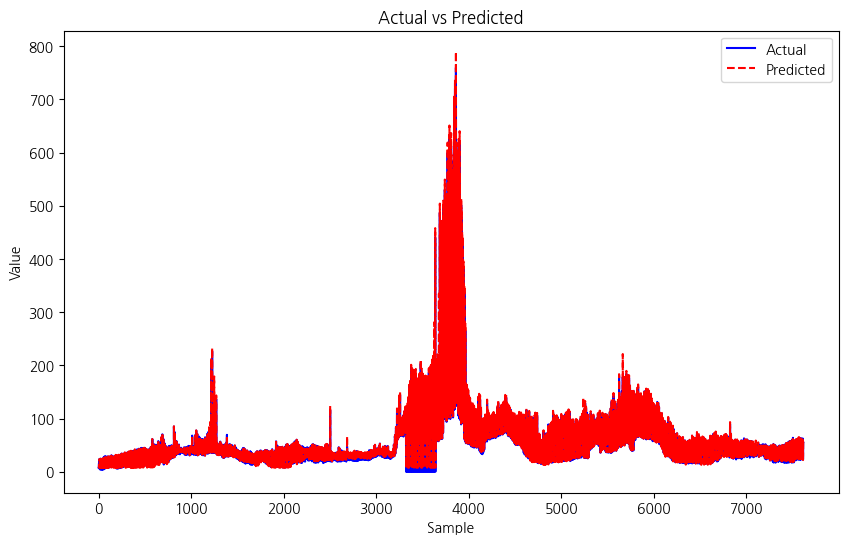

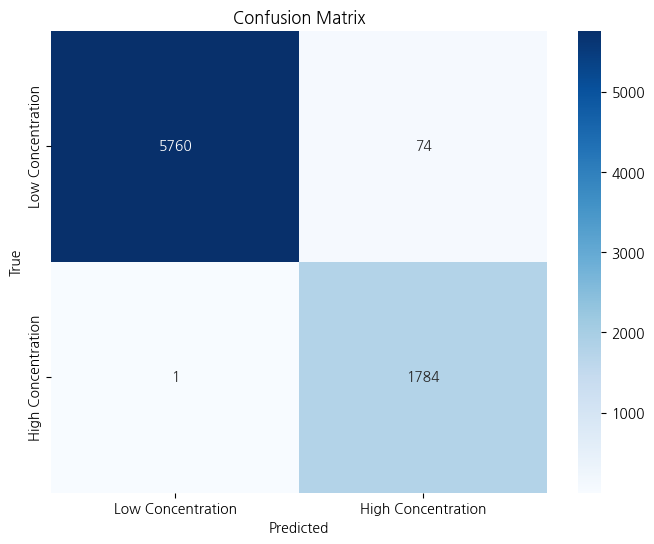

In [24]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = MLP(X_train.shape[1], 1, hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 테스트 데이터에 대한 예측 및 민감도 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
